# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Баранчиков".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from itertools import cycle

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, n_batches=10, random_state=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.n_batches = n_batches
        self.random_state = random_state
        self.beta = None
        self.err = None
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        np.random.seed(self.random_state)
        self.err = []
        # добавляем фиктивный столбец
        X = np.c_[np.ones_like(X[:,0]),X]
        # разбиваем на батчи
        batches = lambda x: MySGDClassifier._batch(x, self.n_batches)
        # инициализируем параметры модели
        self.beta = np.array([1.0/X.shape[1]] * X.shape[1])
        
        for epoch in xrange(1, self.max_epoch+1):
            # перемешиваем выборку
            shuffle_indices = np.random.permutation(np.arange(X.shape[0]))
            X, y = X[shuffle_indices], y[shuffle_indices]
            for X_batch, y_batch in zip(batches(X), batches(y)):
                y_hat = MySGDClassifier.sigmoid(X_batch.dot(self.beta))
                err = y_hat - y_batch
                grad = X_batch.T.dot(err) / X_batch.shape[0]
                reg = self.beta / np.linalg.norm(self.beta)
                self.beta -= (self.alpha*grad + self.C*reg)/epoch
            
            self.err.append(np.linalg.norm(MySGDClassifier.sigmoid(X.dot(self.beta)))/X.shape[0] +
                             np.linalg.norm(self.beta))
            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        raise Exception('partial_fit wasn\'t implement')
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return self.predict_proba(X) > 0.5
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.c_[np.ones_like(X[:,0]),X]
        return MySGDClassifier.sigmoid(X.dot(self.beta))
    
    @staticmethod
    def sigmoid(z):
        return 1.0 / (1 + np.exp(-z))
    
    @staticmethod
    def _batch(iterable, n):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

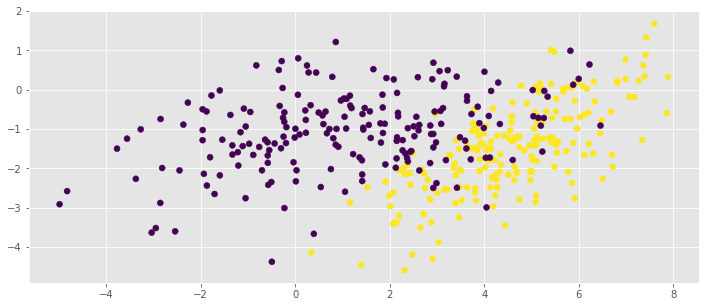

In [244]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [432]:
model = MySGDClassifier(max_epoch=50, n_batches=50,alpha=0.1)
xx = (X - np.mean(X,axis=0)) / np.std(X, axis=0)
model.fit(xx, y)

MySGDClassifier(C=1, alpha=0.1, max_epoch=50, n_batches=50, random_state=None)

In [433]:
print model.beta
#model.err

[ 0.00669806  0.01168071 -0.00507477]


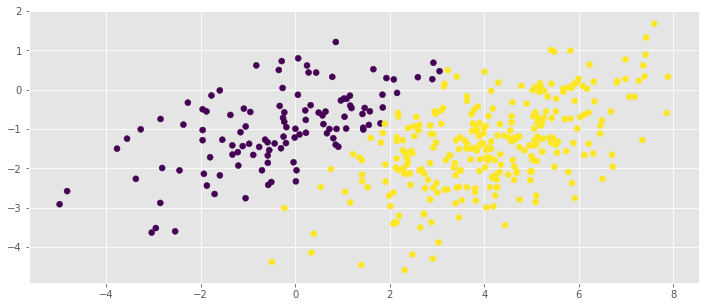

In [434]:
label = model.predict(xx)
plt.scatter(X[:,0], X[:,1], c=label)
plt.show()

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

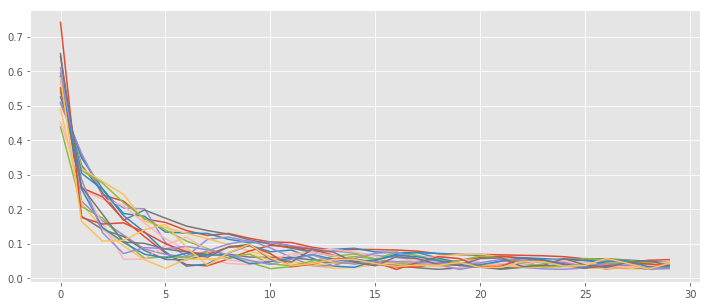

In [437]:
me = 30
for alpha in np.arange(0.01,0.2,0.01):
    model = MySGDClassifier(alpha=alpha, max_epoch=me)
    model.fit(xx, y)
    plt.plot(range(me),model.err)
plt.show()

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [3]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = '../hsdata/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [3]:
df_data.shape

(500000, 45)

In [4]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [5]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [6]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [5]:
from sklearn.preprocessing import OneHotEncoder
def preprocess(df):
    enc = OneHotEncoder(sparse=False)

    dfo = df['opponent_hero_card_id']
    dfp = df['player_hero_card_id']

    s = sorted(set(dfo).union(set(dfp)))
    new_opp = ['opponent_hero_card_id_%d' %idx for idx in s]
    new_pl = ['player_hero_card_id_%d' %idx for idx in s]

    emb = df.loc[:, ['opponent_hero_card_id']].replace({j:i for i,j in zip(xrange(len(s)), s)}).values
    enc_o = enc.fit_transform(emb)
    emb = df.loc[:, ['player_hero_card_id']].replace({j:i for i,j in zip(xrange(len(s)), s)}).values
    enc_p = enc.fit_transform(emb)
    
    del df['opponent_hero_card_id']
    del df['player_hero_card_id']
    
    df = df.join(pd.DataFrame(data=enc_o, columns=new_opp, index=df.index))
    df = df.join(pd.DataFrame(data=enc_p, columns=new_pl, index=df.index))
    
    return df

In [6]:
df_data = preprocess(df_data)

In [18]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1.0,1.0,1.0,1.0,0.0
turn,14.0,7.0,5.0,8.0,13.0
opponent_armor,0.0,0.0,3.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,5.0,22.0,29.0,26.0,30.0
opponent_special_skill_used,0.0,0.0,0.0,0.0,0.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,6.0,4.0,7.0,10.0
opponent_crystals_current,10.0,6.0,1.0,7.0,1.0
opponent_deck_count,11.0,19.0,22.0,17.0,12.0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [7]:
X = df_data.values[:, 1:]
y = df_data.values[:, 0]

In [8]:
del df_data

In [9]:
print X.shape
y.shape

(500000, 59)


(500000,)

In [10]:
model = MySGDClassifier().fit(X, y)

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [11]:
fp = '../hsdata/testData_tabular.csv'
df_test = pd.read_csv(fp, sep=',')

In [12]:
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')
del df_test['decision']
df_test = preprocess(df_test)
df_test.head().T

gamestate_id,6845857.0,9279433.0,6642076.0,9169516.0,8991397.0
turn,12.0,6.0,14.0,7.0,9.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,29.0,12.0,12.0,30.0,30.0
opponent_special_skill_used,1.0,0.0,0.0,0.0,1.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,5.0,10.0,6.0,8.0
opponent_crystals_current,8.0,5.0,0.0,6.0,2.0
opponent_deck_count,16.0,22.0,11.0,20.0,19.0
opponent_fatigue_damage,0.0,0.0,0.0,0.0,0.0


In [13]:
X_test = df_test.values

In [14]:
X_test.shape

(750000, 59)

In [23]:
res = model.predict_proba(X_test)

In [24]:
np.savetxt('res.txt', res, delimiter=',', fmt='%f')

## barash: 0.7414